In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import chisquare
from scipy.stats import ks_2samp

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap


In [51]:
time = sc.read_h5ad("./timecourse_adata_annotated.h5ad")
# b16 = sc.read_h5ad("./B16TBK1sg.h5ad")
# tnk = sc.read_h5ad("./81722tnk.h5ad")

coinhib_genes = ['Pdcd1', 'Tigit', 'Ctla4', 'Havcr2', 'Lag3', 'Entpd1', 'Nt5e', 'Tox']
coinhib_genes = [i for i in coinhib_genes if i in time.var_names.tolist()]
stemlike_genes = ['Ccr7', 'Cxcr5', 'Tcf7', 'Sell']
stemlike_genes = [i for i in stemlike_genes if i in time.var_names.tolist()]

In [58]:
coinhib_genes + ['Cd38'] + stemlike_genes

['Pdcd1',
 'Tigit',
 'Ctla4',
 'Havcr2',
 'Lag3',
 'Entpd1',
 'Nt5e',
 'Tox',
 'Cd38',
 'Ccr7',
 'Cxcr5',
 'Tcf7',
 'Sell']

In [53]:
# Separate by Tissue and Date

tissue = ['Tum', 'nLN', 'dLN']
times = ['d16', 'd10', 'd7']

for tiss in tissue:
    for tim in times:
        temp = time[time.obs['tissue']==tiss]
        temp = temp[temp.obs['date']==tim]
        
        temp = temp[temp.obs['annotation']=="CD8 T cells"]

        temp.X = None
        temp.X = temp.layers['counts'].copy()
        sc.pp.normalize_total(temp,target_sum=100000)
        temp.layers['normcounts'] = temp.X.copy()
        sc.pp.log1p(temp)
        temp.layers['lognormcounts'] = temp.X.copy()
        
        allcorr = compute_all_correlations(adata=temp)
        allcorr['dist'] = np.sqrt(np.square(allcorr['Correlation with co-inhibitory genes']) + np.square(allcorr['Correlation with stem-like genes']))
        allcorr.index = allcorr['gene']
        allcorr.to_csv("./time_corr/{}_{}.csv".format(tiss, tim))

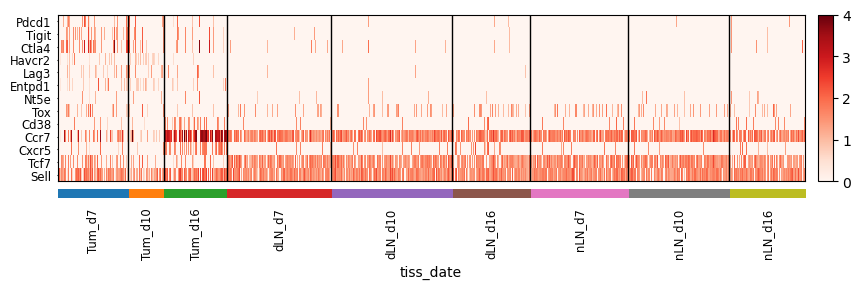

In [61]:
time.obs['tiss_date'] = time.obs['tissue'].astype(str) + "_" + time.obs['date'].astype(str)
sc.pl.heatmap(time, coinhib_genes + ['Cd38'] + stemlike_genes, groupby = "tiss_date", swap_axes=True, cmap='Reds', vmax=4)

In [17]:
allcorr = compute_all_correlations(adata=time)
allcorr['dist'] = np.sqrt(np.square(allcorr['Correlation with co-inhibitory genes']) + np.square(allcorr['Correlation with stem-like genes']))
allcorr.index = allcorr['gene']
allcorr.to_csv("time_corr/{}_{}.csv".format(tiss, tim))
allcorr

gene  Correlation with co-inhibitory genes  \
gene                                                                   
Sox17                    Sox17                              0.000962   
Mrpl15                  Mrpl15                              0.089502   
Lypla1                  Lypla1                              0.112204   
Tcea1                    Tcea1                              0.088789   
Atp6v1h                Atp6v1h                              0.045027   
...                        ...                                   ...   
AC168977.2          AC168977.2                              0.004011   
AC168977.1          AC168977.1                              0.007835   
PISD                      PISD                              0.034924   
DHRSX                    DHRSX                              0.071950   
CAAA01147332.1  CAAA01147332.1                              0.330580   

                p-val of Correlation with co-inhibitory genes  \
gene                                                            
Sox17                                            9.181974e-01   
Mrpl15                                           9.919050e-22   
Lypla1                                           2.757741e-33   
Tcea1                                            2.077099e-21   
Atp6v1h                                          1.500663e-06   
...                                                       ...   
AC168977.2                                       6.683820e-01   
AC168977.1                                       4.027468e-01   
PISD                                             1.907645e-04   
DHRSX                                            1.426042e-14   
CAAA01147332.1                                  5.245315e-289   

                Correlation with stem-like genes  \
gene                                               
Sox17                                   0.016093   
Mrpl15                                 -0.029301   
Lypla1                                 -0.047494   
Tcea1                                  -0.008279   
Atp6v1h                                -0.006046   
...                                          ...   
AC168977.2                             -0.006108   
AC168977.1                              0.016271   
PISD                                    0.028980   
DHRSX                                  -0.035789   
CAAA01147332.1                         -0.207304   

                p-val of Correlation with stem-like genes      dist  
gene                                                                 
Sox17                                        8.565133e-02  0.016122  
Mrpl15                                       1.748604e-03  0.094176  
Lypla1                                       3.873569e-07  0.121842  
Tcea1                                        3.766104e-01  0.089174  
Atp6v1h                                      5.184623e-01  0.045431  
...                                                   ...       ...  
AC168977.2                                   5.141979e-01  0.007307  
AC168977.1                                   8.224820e-02  0.018059  
PISD                                         1.964030e-03  0.045382  
DHRSX                                        1.316163e-04  0.080360  
CAAA01147332.1                              5.777559e-111  0.390202  

[15451 rows x 6 columns]

In [18]:
coinhib_genes

['Pdcd1', 'Tigit', 'Ctla4', 'Havcr2', 'Lag3', 'Entpd1', 'Nt5e', 'Tox']

In [19]:
stemlike_genes

['Ccr7', 'Cxcr5', 'Tcf7', 'Sell']

Text(0.5, 1.0, '')

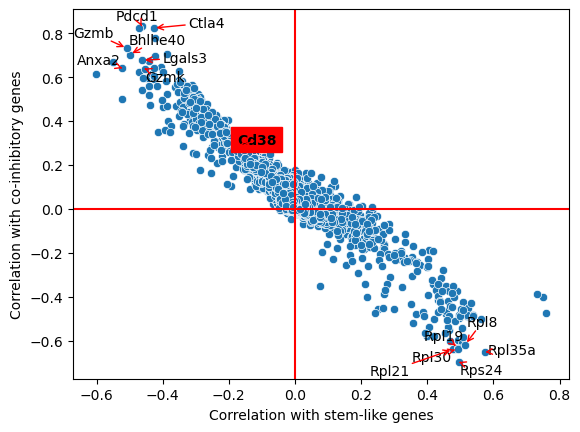

In [77]:
#make plot
ax=sns.scatterplot(data=allcorr, x="Correlation with stem-like genes", y="Correlation with co-inhibitory genes")
ax.axvline(color='r')
ax.axhline(color='r')

#get indices of rows to annotate
idx = allcorr.sort_values(by="dist", ascending=False)[:25:2].index.tolist()
#idx.append("Cd38")

texts = [plt.text(allcorr.loc[r]["Correlation with stem-like genes"],
                  allcorr.loc[r]["Correlation with co-inhibitory genes"],
                  allcorr.loc[r]["gene"],ha='center',va='center') for r in idx]

r = "Cd38"
texts.append(plt.text(allcorr.loc[r]["Correlation with stem-like genes"],
                  allcorr.loc[r]["Correlation with co-inhibitory genes"],
                  allcorr.loc[r]["gene"],ha='center',va='center',fontweight='bold', backgroundcolor='red'))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'));
plt.title("")

# #loop over those rows to annotate
# for i,row in allcorr.loc[idx].iterrows():
#     ax.text(row["Correlation with stem-like genes"], row["Correlation with co-inhibitory genes"], row["gene"])
    
# row = allcorr.loc['Cd38']
# ax.text(row["Correlation with stem-like genes"], row["Correlation with co-inhibitory genes"], row["gene"])

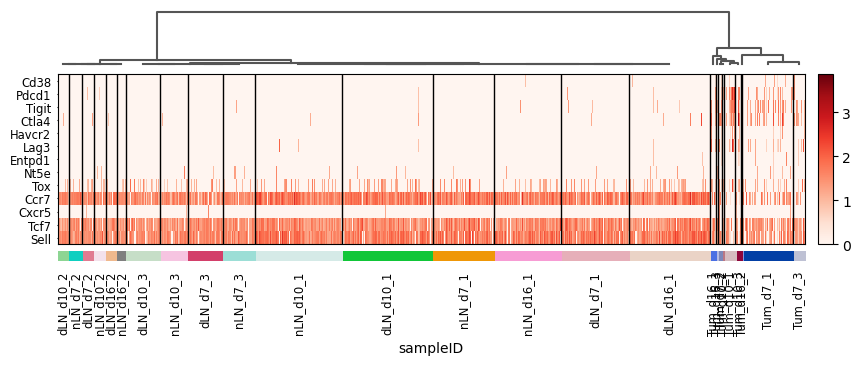

In [20]:
markers = ['Cd38'] + coinhib_genes + stemlike_genes
sc.pl.heatmap(time, markers, swap_axes=True, dendrogram=True, groupby="sampleID", cmap='Reds')

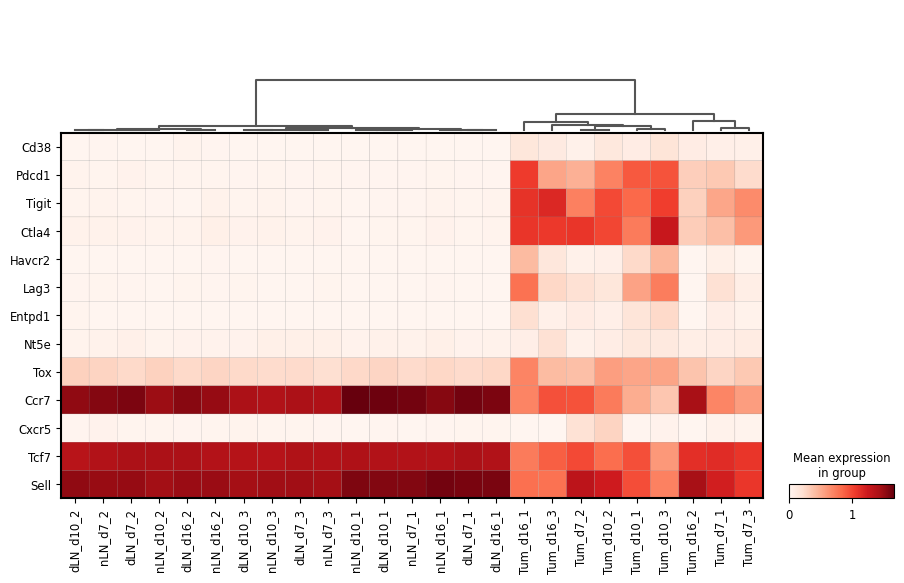

In [21]:
sc.pl.matrixplot(time, markers, swap_axes=True, dendrogram=True, groupby="sampleID", cmap='Reds')

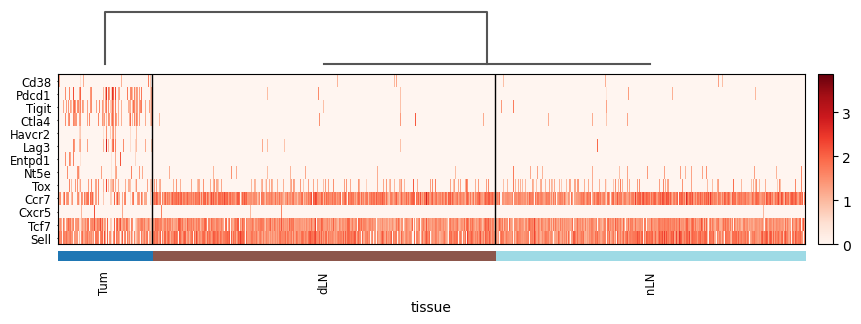

In [22]:
sc.pl.heatmap(time, markers, swap_axes=True, dendrogram=True, groupby="tissue", cmap='Reds')

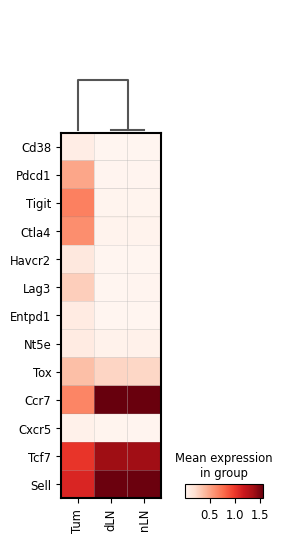

In [23]:
sc.pl.matrixplot(time, markers, swap_axes=True, dendrogram=True, groupby="tissue", cmap='Reds')

In [24]:
sc.tl.pca(time,svd_solver='arpack')
sc.pp.neighbors(time, n_neighbors=30, n_pcs=50)
sc.tl.umap(time)

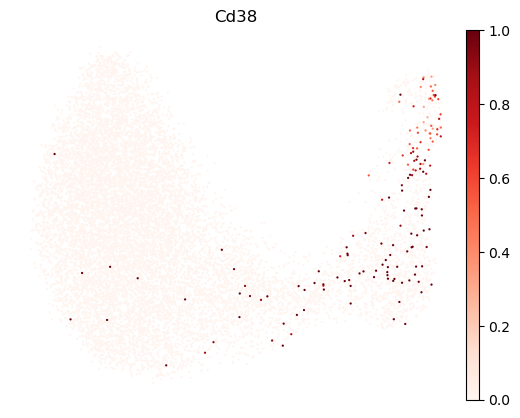

In [55]:
sc.pl.umap(time, color="Cd38", cmap="Reds", frameon=False, vmax=1)

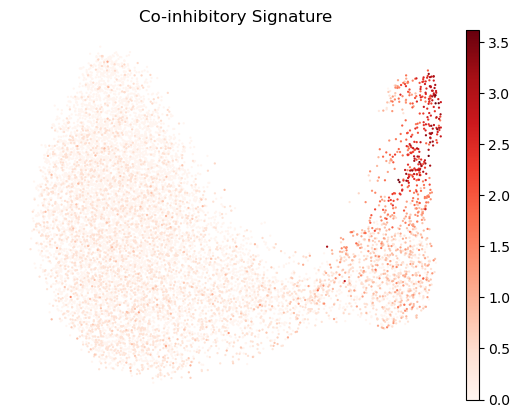

In [26]:
ax = sc.pl.umap(time, color="coinhib genes", cmap="Reds", frameon=False, show=False)
ax.set_title("Co-inhibitory Signature");

In [ ]:
time.obs['coinhib genes scaled'] = (time.obs['coinhib genes'] - np.min(time.obs['coinhib genes'])) / (np.max(time.obs['coinhib genes']) - np.min(time.obs['coinhib genes']))

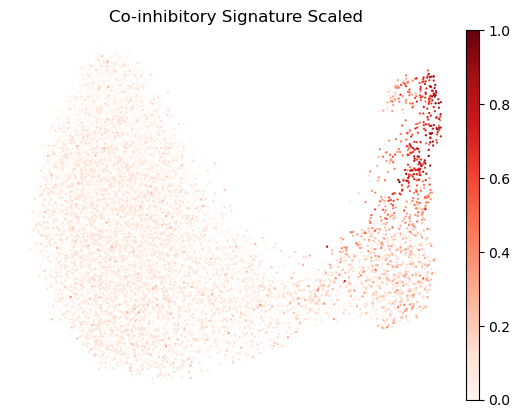

In [29]:
ax = sc.pl.umap(time, color="coinhib genes scaled", cmap="Reds", frameon=False, show=False)
ax.set_title("Co-inhibitory Signature Scaled");

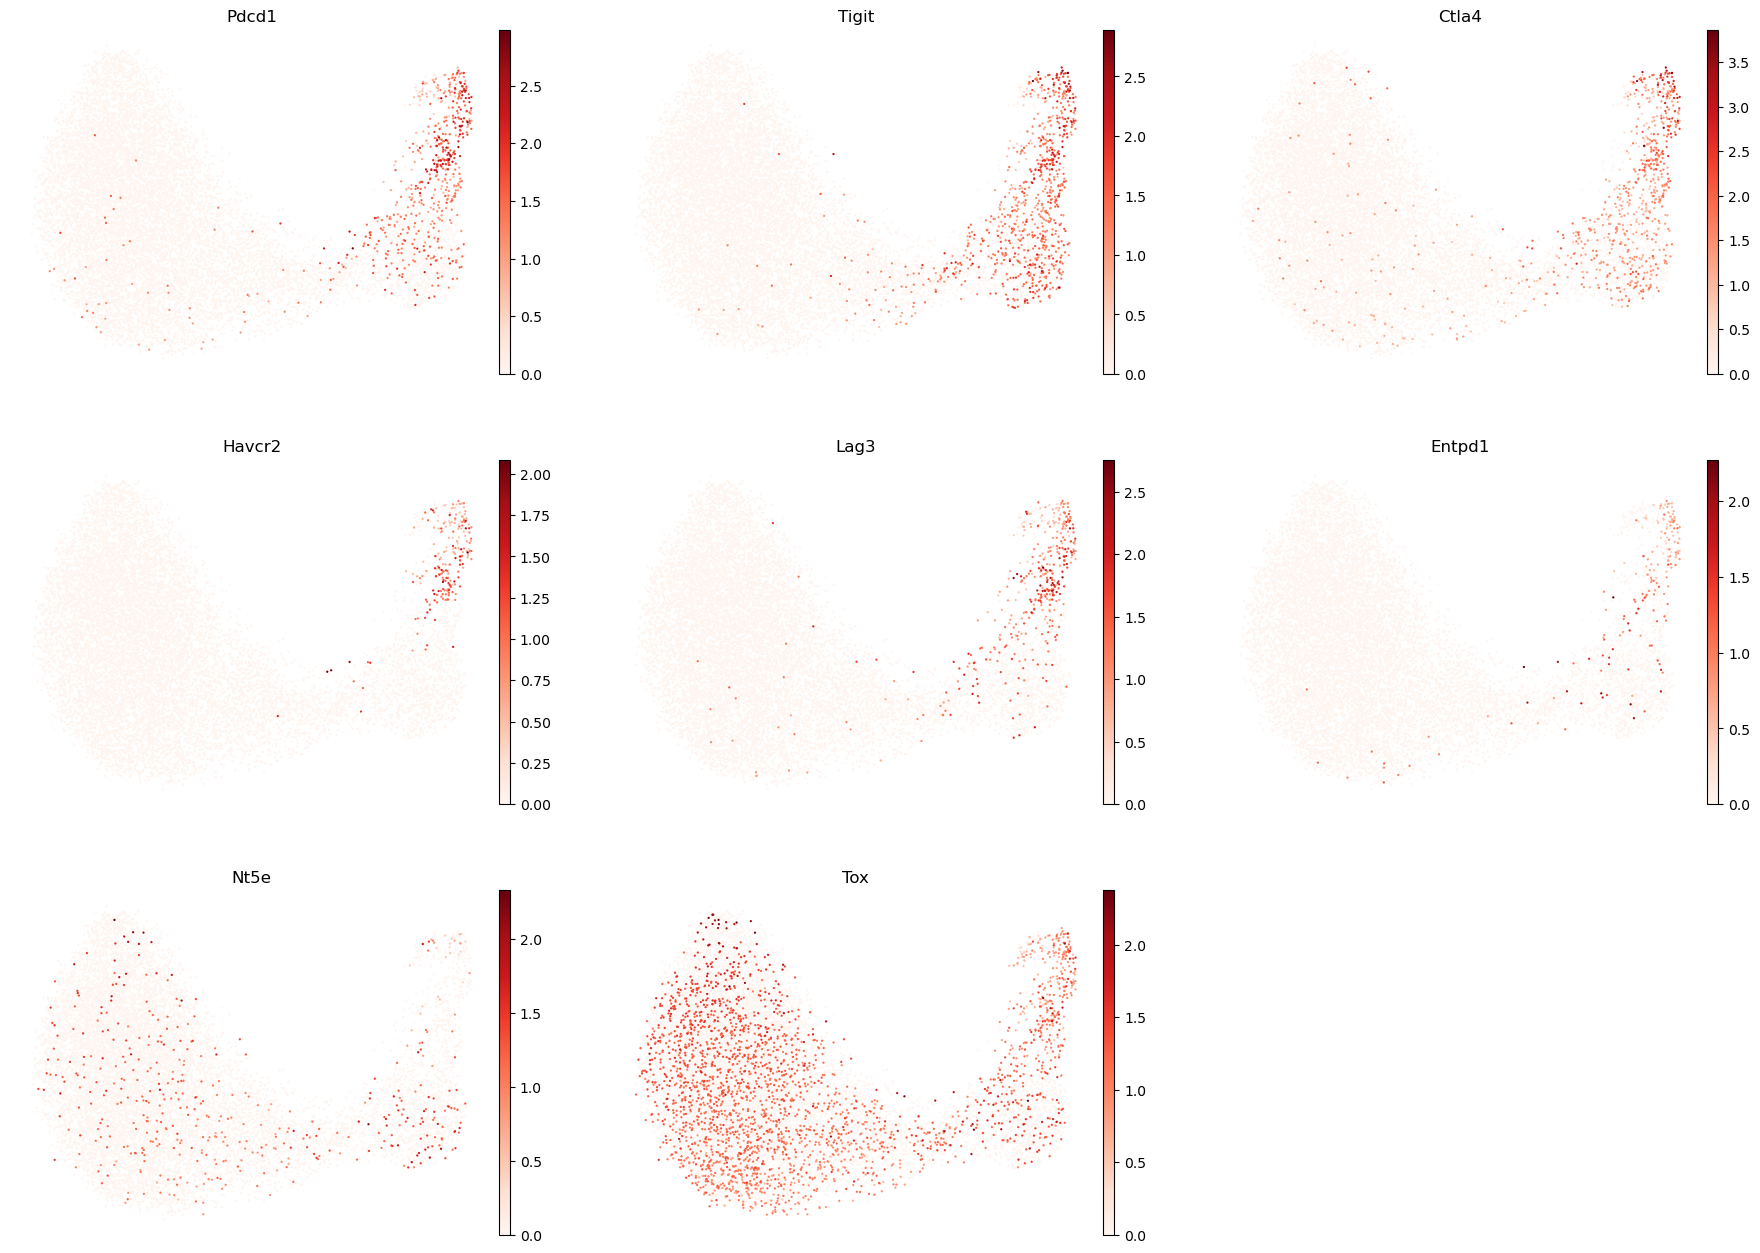

In [30]:
sc.pl.umap(time, color=coinhib_genes, cmap="Reds", frameon=False, ncols=3)

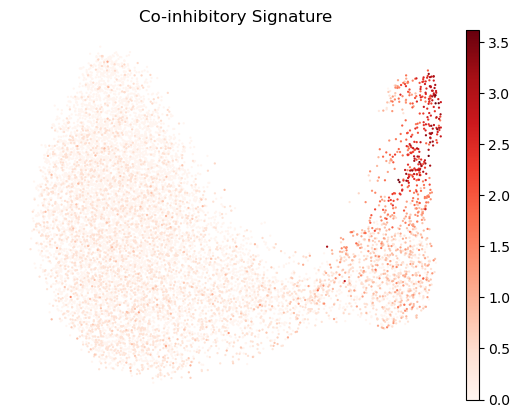

In [31]:
ax = sc.pl.umap(time, color="coinhib genes", cmap="Reds", frameon=False, show=False)
ax.set_title("Co-inhibitory Signature");

In [46]:
tnk = sc.read_h5ad("./adatas/b16_raw_adatas/B16ovatbk1/81722tnk.h5ad")
tnk.obs

percent_mito  n_genes_by_counts  \
AAACCCACACCGTGAC-1-0       0.016377                526   
AAACGCTCAGGCGTTC-1-0       0.008368                579   
AAAGGGCTCCTCTCTT-1-0       0.011976                788   
AACGAAACATTGCTGA-1-0       0.009370               1035   
AAGACAAAGTAGGGTC-1-0       0.011249               1688   
...                             ...                ...   
TTTGACTGTACCTGTA-1-14      0.022595                667   
TTTGACTTCCTATGGA-1-14      0.018400               1340   
TTTGGAGTCTATGCCC-1-14      0.033835                329   
TTTGGTTTCCCGTTGT-1-14      0.022137                536   
TTTGTTGCAAGGTCTT-1-14      0.035528                555   

                       log1p_n_genes_by_counts  total_counts  \
AAACCCACACCGTGAC-1-0                  6.267201         977.0   
AAACGCTCAGGCGTTC-1-0                  6.363028         956.0   
AAAGGGCTCCTCTCTT-1-0                  6.670766        1503.0   
AACGAAACATTGCTGA-1-0                  6.943122        2348.0   
AAGACAAAGTAGGGTC-1-0                  7.431892        5156.0   
...                                        ...           ...   
TTTGACTGTACCTGTA-1-14                 6.504288        1372.0   
TTTGACTTCCTATGGA-1-14                 7.201171        3424.0   
TTTGGAGTCTATGCCC-1-14                 5.799093         532.0   
TTTGGTTTCCCGTTGT-1-14                 6.285998        1039.0   
TTTGTTGCAAGGTCTT-1-14                 6.320768         957.0   

                       log1p_total_counts  pct_counts_in_top_50_genes  \
AAACCCACACCGTGAC-1-0             6.885509                   40.634596   
AAACGCTCAGGCGTTC-1-0             6.863803                   37.761506   
AAAGGGCTCCTCTCTT-1-0             7.315884                   35.262808   
AACGAAACATTGCTGA-1-0             7.761745                   36.669506   
AAGACAAAGTAGGGTC-1-0             8.548110                   32.020946   
...                                   ...                         ...   
TTTGACTGTACCTGTA-1-14            7.224753                   41.618076   
TTTGACTTCCTATGGA-1-14            8.138857                   38.084112   
TTTGGAGTCTATGCCC-1-14            6.278522                   44.736842   
TTTGGTTTCCCGTTGT-1-14            6.946976                   42.059673   
TTTGTTGCAAGGTCTT-1-14            6.864848                   36.990596   

                       pct_counts_in_top_100_genes  \
AAACCCACACCGTGAC-1-0                     53.224156   
AAACGCTCAGGCGTTC-1-0                     48.221757   
AAAGGGCTCCTCTCTT-1-0                     46.640053   
AACGAAACATTGCTGA-1-0                     46.592845   
AAGACAAAGTAGGGTC-1-0                     43.599690   
...                                            ...   
TTTGACTGTACCTGTA-1-14                    53.790087   
TTTGACTTCCTATGGA-1-14                    48.422897   
TTTGGAGTCTATGCCC-1-14                    56.954887   
TTTGGTTTCCCGTTGT-1-14                    53.609240   
TTTGTTGCAAGGTCTT-1-14                    48.380355   

                       pct_counts_in_top_200_genes  \
AAACCCACACCGTGAC-1-0                     66.632549   
AAACGCTCAGGCGTTC-1-0                     60.355649   
AAAGGGCTCCTCTCTT-1-0                     60.545576   
AACGAAACATTGCTGA-1-0                     59.156729   
AAGACAAAGTAGGGTC-1-0                     56.225756   
...                                            ...   
TTTGACTGTACCTGTA-1-14                    65.962099   
TTTGACTTCCTATGGA-1-14                    59.462617   
TTTGGAGTCTATGCCC-1-14                    75.751880   
TTTGGTTTCCCGTTGT-1-14                    67.661213   
TTTGTTGCAAGGTCTT-1-14                    62.904911   

                       pct_counts_in_top_500_genes  n_genes  doublet_score  \
AAACCCACACCGTGAC-1-0                     97.338792      526       0.039763   
AAACGCTCAGGCGTTC-1-0                     91.736402      579       0.016153   
AAAGGGCTCCTCTCTT-1-0                     80.838323      788       0.114883   
AACGAAACATTGCTGA-1-0                     77.214651     1035       0.01

In [52]:
coinhib_genes = ['Pdcd1', 'Tigit', 'Ctla4', 'Havcr2', 'Lag3', 'Entpd1', 'Nt5e', 'Tox']
coinhib_genes = [i for i in coinhib_genes if i in tnk.var_names.tolist()]
stemlike_genes = ['Ccr7', 'Cxcr5', 'Tcf7', 'Sell']
stemlike_genes = [i for i in stemlike_genes if i in tnk.var_names.tolist()]

tnk.obs['broad_ct'] = tnk.obs['label_ftnk_nodub'].str.split(' ').str[-1]
tnk = tnk[tnk.obs['broad_ct']=="CD8s"]

treats_of_int = {'aPD1', 'Isotype'}
tnk = tnk[tnk.obs['treatment'].isin(treats_of_int)]
tnk = tnk[tnk.obs['']]

# tnk.X = None
# tnk.X = tnk.layers['counts'].copy()
# sc.pp.normalize_total(tnk,target_sum=100000)
# tnk.layers['normcounts'] = tnk.X.copy()
# sc.pp.log1p(tnk)
tnk.layers['lognormcounts'] = tnk.X.copy()
tnk.raw = tnk.copy()

# Identify Cells that are high in expression of Cd38
# genedf = sc.get.obs_df(tnk,keys=["Cd38"])
# tnk.obs["Cd38_HL"] = genedf['Cd38']>0.25
# tnk.obs['Cd38_expr'] = genedf['Cd38']

tnk.obs['coinhib genes'] = np.mean(tnk[:, coinhib_genes].X, axis=1)
tnk.obs['stemlike genes'] = np.mean(tnk[:, stemlike_genes].X, axis=1)
tnk.obs['coinhib genes scaled'] = (tnk.obs['coinhib genes'] - np.min(tnk.obs['coinhib genes'])) / (np.max(tnk.obs['coinhib genes']) - np.min(tnk.obs['coinhib genes']))
cell_metadata = tnk.obs

In [50]:
allcorr = compute_all_correlations(adata=tnk)
allcorr['dist'] = np.sqrt(np.square(allcorr['Correlation with co-inhibitory genes']) + np.square(allcorr['Correlation with stem-like genes']))
allcorr.index = allcorr['gene']
allcorr.to_csv("fig1a_correlations_tnk_iso_.csv")
allcorr

gene  Correlation with co-inhibitory genes  \
gene                                                                   
Mrpl15                  Mrpl15                              0.104989   
Lypla1                  Lypla1                              0.099067   
Gm37988                Gm37988                             -0.020625   
Tcea1                    Tcea1                              0.167926   
Atp6v1h                Atp6v1h                              0.070612   
...                        ...                                   ...   
AC125149.3          AC125149.3                             -0.008922   
AC168977.1          AC168977.1                             -0.011860   
AC149090.1          AC149090.1                              0.117481   
CAAA01118383.1  CAAA01118383.1                              0.096560   
CAAA01147332.1  CAAA01147332.1                              0.043544   

                p-val of Correlation with co-inhibitory genes  \
gene                                                            
Mrpl15                                               0.003538   
Lypla1                                               0.005936   
Gm37988                                              0.567685   
Tcea1                                                0.000003   
Atp6v1h                                              0.050151   
...                                                       ...   
AC125149.3                                           0.804769   
AC168977.1                                           0.742470   
AC149090.1                                           0.001091   
CAAA01118383.1                                       0.007332   
CAAA01147332.1                                       0.227471   

                Correlation with stem-like genes  \
gene                                               
Mrpl15                                 -0.113320   
Lypla1                                 -0.085235   
Gm37988                                 0.067596   
Tcea1                                  -0.063897   
Atp6v1h                                -0.031237   
...                                          ...   
AC125149.3                              0.054742   
AC168977.1                              0.022113   
AC149090.1                             -0.060639   
CAAA01118383.1                         -0.030731   
CAAA01147332.1                          0.007411   

                p-val of Correlation with stem-like genes      dist  
gene                                                                 
Mrpl15                                           0.001635  0.154480  
Lypla1                                           0.017998  0.130688  
Gm37988                                          0.060818  0.070673  
Tcea1                                            0.076393  0.179672  
Atp6v1h                                          0.386709  0.077213  
...                                                   ...       ...  
AC125149.3                                       0.129087  0.055465  
AC168977.1                                       0.540084  0.025093  
AC149090.1                                       0.092670  0.132207  
CAAA01118383.1                                   0.394457  0.101333  
CAAA01147332.1                                   0.837325  0.044170  

[13496 rows x 6 columns]

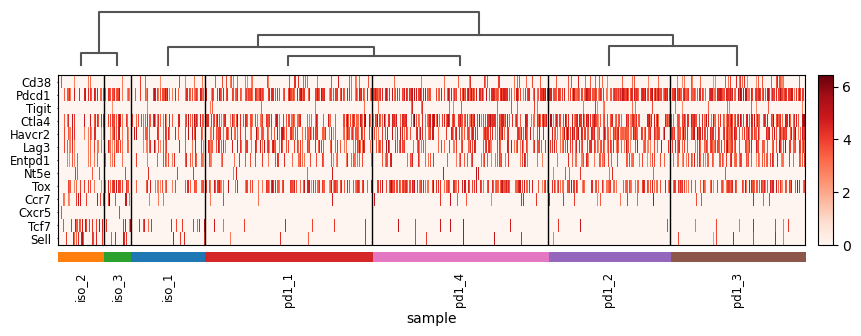

In [37]:
markers = ['Cd38'] + coinhib_genes + stemlike_genes
sc.pl.heatmap(tnk, markers, swap_axes=True, dendrogram=True, groupby="sample", cmap='Reds')

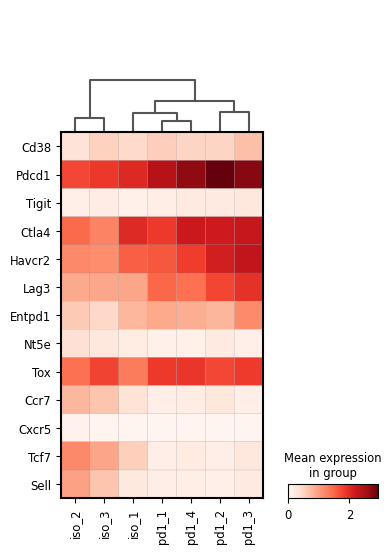

In [38]:
sc.pl.matrixplot(tnk, markers, swap_axes=True, dendrogram=True, groupby="sample", cmap='Reds')

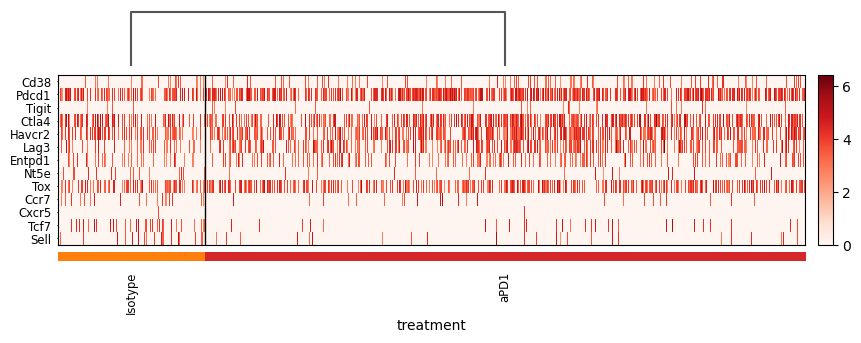

In [39]:
sc.pl.heatmap(tnk, markers, swap_axes=True, dendrogram=True, groupby="treatment", cmap='Reds')

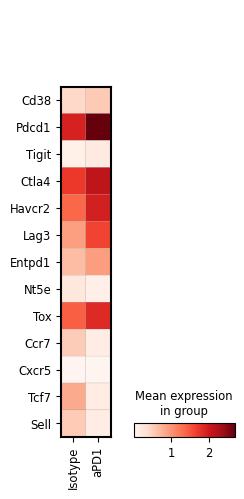

In [40]:
sc.pl.matrixplot(tnk, markers, swap_axes=True, dendrogram=True, groupby="treatment", cmap='Reds')

In [53]:
sc.tl.pca(tnk,svd_solver='arpack')
sc.pp.neighbors(tnk, n_neighbors=30, n_pcs=50)
sc.tl.umap(tnk)

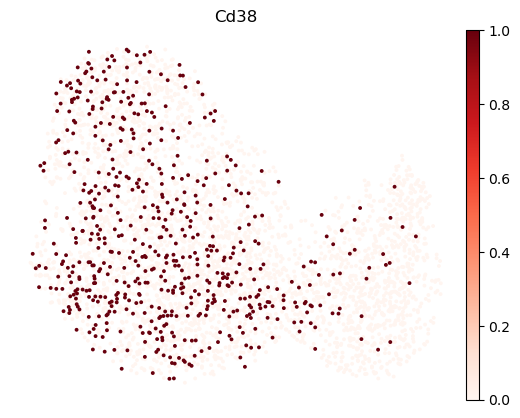

In [54]:
sc.pl.umap(tnk, color="Cd38", cmap="Reds", frameon=False, vmax=1)

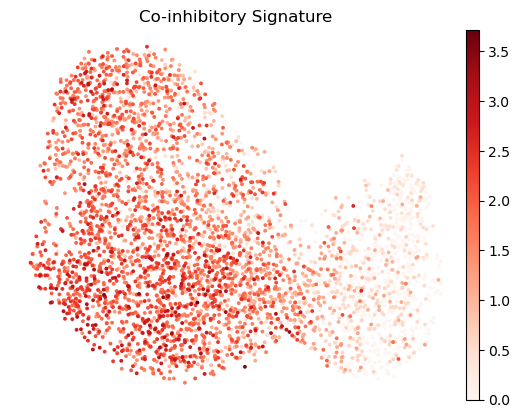

In [10]:
ax = sc.pl.umap(tnk, color="coinhib genes", cmap="Reds", frameon=False, show=False)
ax.set_title("Co-inhibitory Signature");

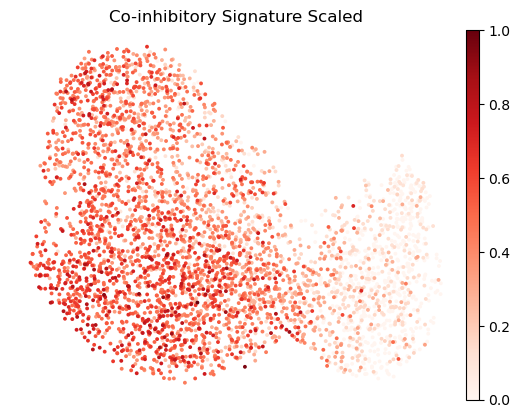

In [11]:
ax = sc.pl.umap(tnk, color="coinhib genes scaled", cmap="Reds", frameon=False, show=False)
ax.set_title("Co-inhibitory Signature Scaled");

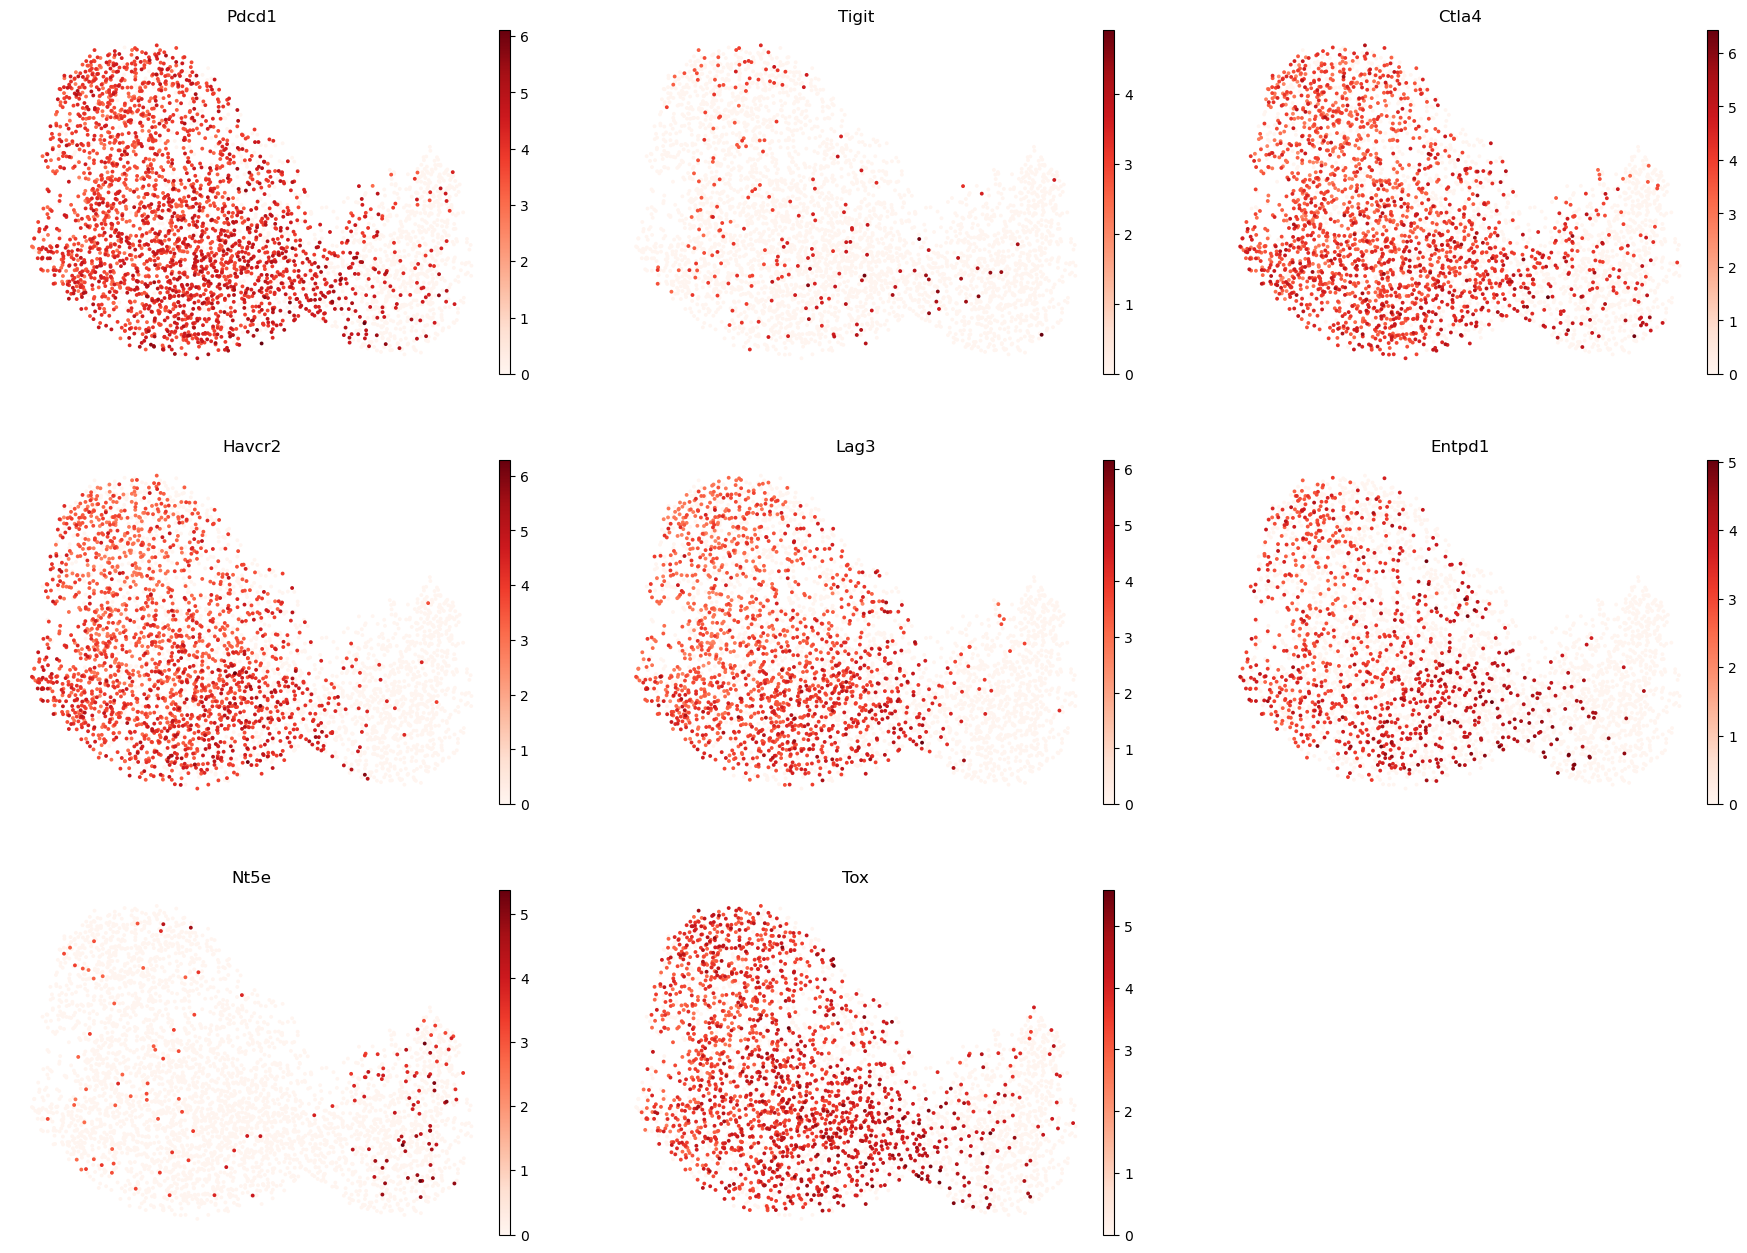

In [12]:
sc.pl.umap(tnk, color=coinhib_genes, cmap="Reds", frameon=False, ncols=3)

In [13]:
coinhib_genes

['Pdcd1', 'Tigit', 'Ctla4', 'Havcr2', 'Lag3', 'Entpd1', 'Nt5e', 'Tox']

In [14]:
stemlike_genes

['Ccr7', 'Cxcr5', 'Tcf7', 'Sell']

In [2]:
feldman = sc.read_h5ad("./adatas/feldman_2018_celltyped.h5ad")
cd8s = {"Exhausted CD8+ T Cells","Exhausted/HS CD8+ T Cells"}
feldman = feldman[feldman.obs.Celltype.isin(cd8s)]

feldman.layers['orig'] = feldman.X.copy()
sc.pp.normalize_total(feldman,target_sum=100000)
feldman.layers['normcounts'] = feldman.X.copy()
sc.pp.log1p(feldman)
feldman.layers['lognormcounts'] = feldman.X.copy()
sc.tl.pca(feldman, svd_solver='arpack')
sc.pp.neighbors(feldman, n_neighbors=5, n_pcs=50)
sc.tl.umap(feldman)
sc.tl.tsne(feldman)

feldman.obs['response'] = feldman.obs['characteristics: response']
feldman.obs['time'] = feldman.obs['characteristics: patient ID (Pre=baseline; Post= on treatment)'].str.split("_").str[0]
feldman

/home/pjoshua/miniconda3/envs/squidpy-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 3878 × 55737
    obs: 'Sample name', 'title', 'source name', 'organism', 'characteristics: patient ID (Pre=baseline; Post= on treatment)', 'characteristics: response', 'characteristics: therapy', 'Cluster number', 'Celltype', 'response', 'time'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'TPM', 'orig', 'normcounts', 'lognormcounts'
    obsp: 'distances', 'connectivities'

/home/pjoshua/miniconda3/envs/squidpy-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pjoshua/miniconda3/envs/squidpy-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


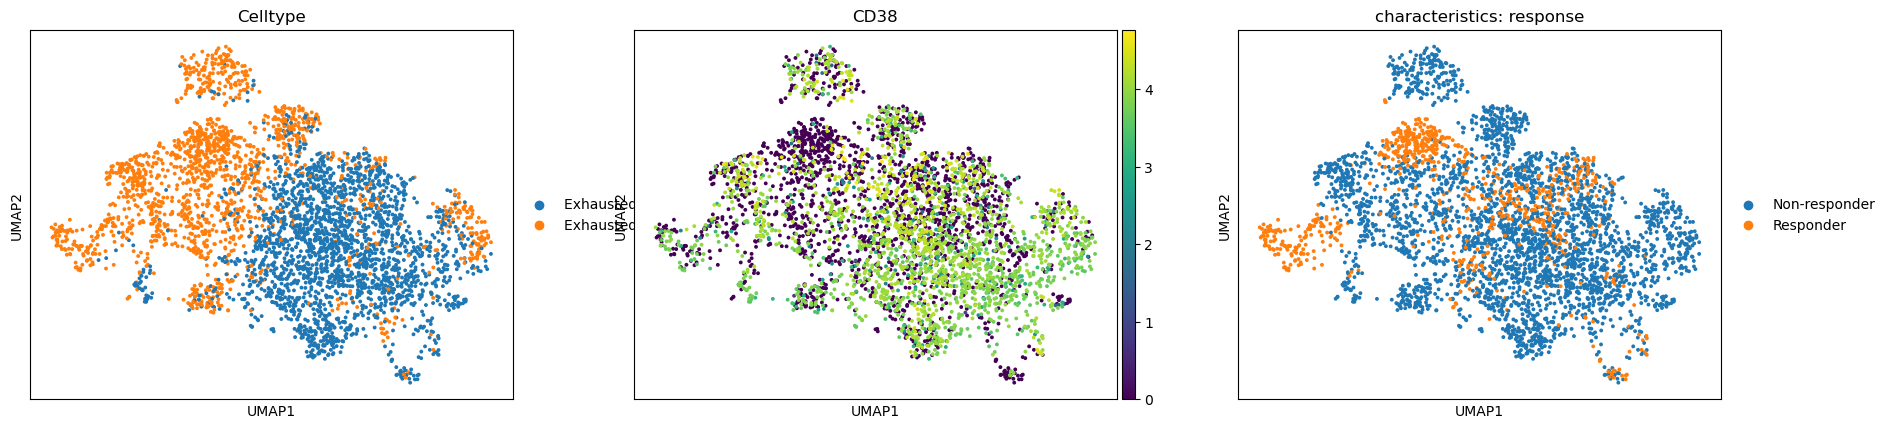

In [4]:
sc.pl.umap(feldman, color=["Celltype", "CD38", "characteristics: response"])

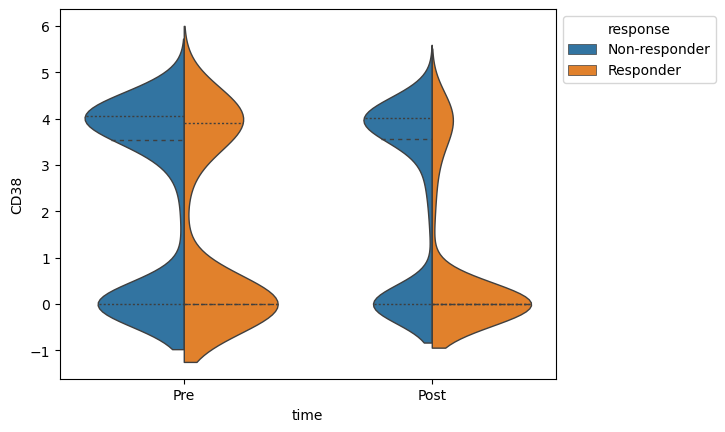

In [4]:
df = sc.get.obs_df(feldman, ["CD38", "time","response","characteristics: therapy"])
ax = sns.violinplot(data=df, x='time', y='CD38', hue="response",order=[ "Pre", "Post"],
                    split=True, inner="quart", linewidth=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<Axes: xlabel='time', ylabel='CD38'>

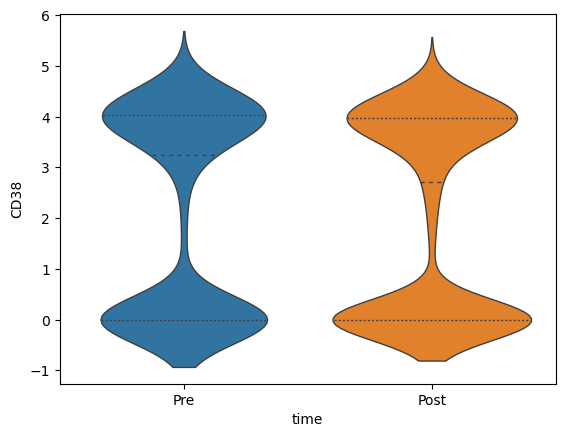

In [41]:
sns.violinplot(data=df, x='time', y='CD38', inner="quart", linewidth=1,order=[ "Pre", "Post"])

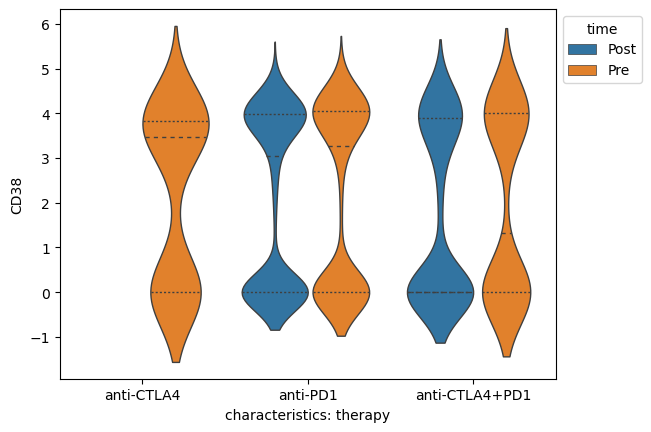

In [50]:
ax = sns.violinplot(data=df, x='characteristics: therapy', y='CD38', hue="time",order=[ "anti-CTLA4", "anti-PD1", "anti-CTLA4+PD1"],
                    inner="quart", linewidth=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

[Text(0.5, 1.0, 'CD38 expression in anti-CTLA4')]

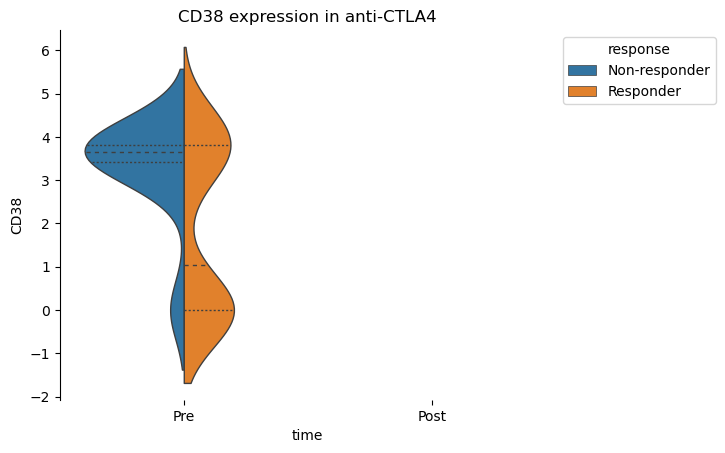

In [17]:
df = sc.get.obs_df(feldman, ["CD38", "time","response","characteristics: therapy"])
ax = sns.violinplot(data=df[df['characteristics: therapy'] == 'anti-CTLA4'], x='time', y='CD38', hue="response",order=[ "Pre", "Post"],
                    split=True, inner="quart", linewidth=1, legend=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine(left=False, bottom=True)
ax.set(title='CD38 expression in anti-CTLA4');

In [19]:
sns.set(font_scale=1.5)

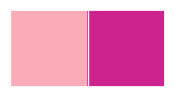

In [13]:
sequential_colors = sns.color_palette("RdPu", 2)
sns.palplot(sequential_colors)

In [20]:
palette = ["#808080", "#992F98"]

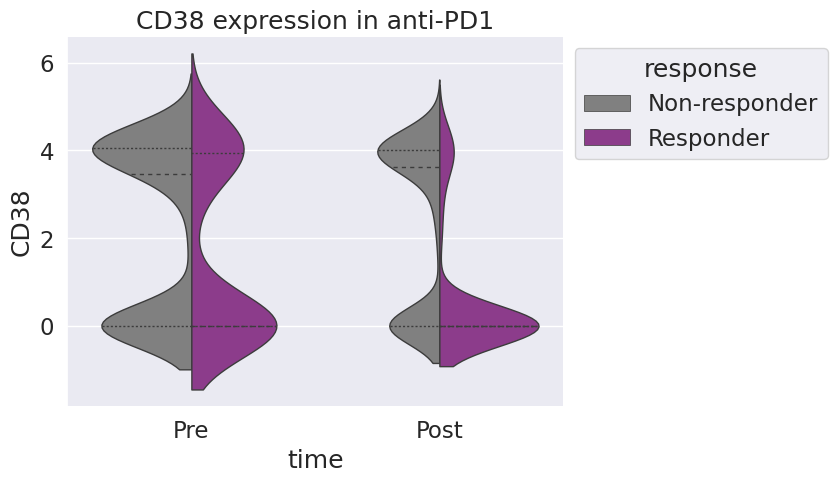

In [24]:
df = sc.get.obs_df(feldman, ["CD38", "time","response","characteristics: therapy"])
ax = sns.violinplot(data=df[df['characteristics: therapy'] == 'anti-PD1'], x='time', y='CD38', hue="response",order=[ "Pre", "Post"],
                    split=True, inner="quart", linewidth=1, legend=False, palette=sns.color_palette(palette, 2))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine(left=False, bottom=True)
ax.set(title='CD38 expression in anti-PD1');
ax.figure.savefig('cd38_expr_in_aPD1.png',dpi=600, bbox_inches='tight')

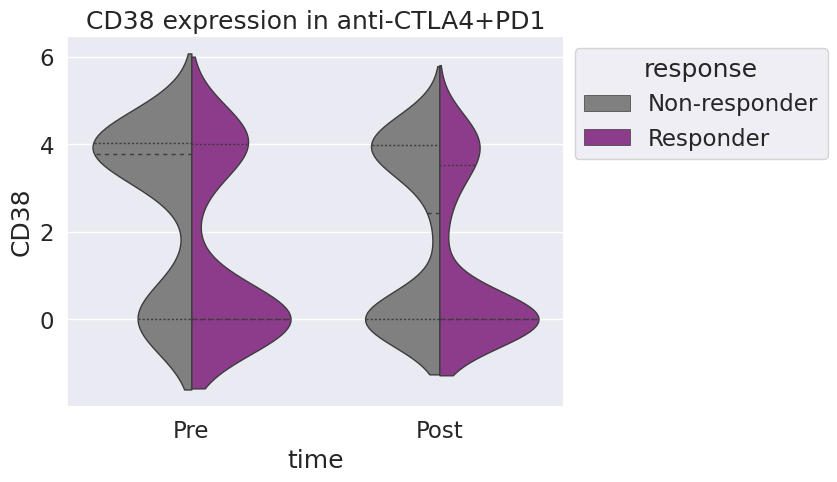

In [25]:
df = sc.get.obs_df(feldman, ["CD38", "time","response","characteristics: therapy"])
ax = sns.violinplot(data=df[df['characteristics: therapy'] == 'anti-CTLA4+PD1'], x='time', y='CD38', hue="response",order=[ "Pre", "Post"],
                    split=True, inner="quart", linewidth=1, palette=sns.color_palette(palette, 2))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine(left=False, bottom=True)
ax.set(title='CD38 expression in anti-CTLA4+PD1');
ax.figure.savefig('cd38_expr_in_CTLA4_aPD1.png',dpi=600, bbox_inches='tight')

In [4]:
feldman.obs

Sample name                       title  \
title                                                                  
A12_P6_M11                      Sample 6                  A12_P6_M11   
A4_P3_M11                      Sample 11                   A4_P3_M11   
A4_P4_M11                      Sample 12                   A4_P4_M11   
A6_P6_M11                      Sample 18                   A6_P6_M11   
A9_P4_M11                      Sample 24                   A9_P4_M11   
...                                  ...                         ...   
G8_P5_M67_L001_T_enriched   Sample 16278   G8_P5_M67_L001_T_enriched   
H11_P5_M67_L001_T_enriched  Sample 16281  H11_P5_M67_L001_T_enriched   
H12_P5_M67_L001_T_enriched  Sample 16282  H12_P5_M67_L001_T_enriched   
H3_P5_M67_L001_T_enriched   Sample 16285   H3_P5_M67_L001_T_enriched   
H8_P5_M67_L001_T_enriched   Sample 16290   H8_P5_M67_L001_T_enriched   

                                     source name      organism  \
title                                                            
A12_P6_M11                  Melanoma single cell  Homo sapiens   
A4_P3_M11                   Melanoma single cell  Homo sapiens   
A4_P4_M11                   Melanoma single cell  Homo sapiens   
A6_P6_M11                   Melanoma single cell  Homo sapiens   
A9_P4_M11                   Melanoma single cell  Homo sapiens   
...                                          ...           ...   
G8_P5_M67_L001_T_enriched   Melanoma single cell  Homo sapiens   
H11_P5_M67_L001_T_enriched  Melanoma single cell  Homo sapiens   
H12_P5_M67_L001_T_enriched  Melanoma single cell  Homo sapiens   
H3_P5_M67_L001_T_enriched   Melanoma single cell  Homo sapiens   
H8_P5_M67_L001_T_enriched   Melanoma single cell  Homo sapiens   

                           characteristics: patient ID (Pre=baseline; Post= on treatment)  \
title                                                                                       
A12_P6_M11                                                             Pre_P1               
A4_P3_M11                                                              Pre_P1               
A4_P4_M11                                                              Pre_P1               
A6_P6_M11                                                              Pre_P1               
A9_P4_M11                                                              Pre_P1               
...                                                                       ...               
G8_P5_M67_L001_T_enriched                                             Post_P6               
H11_P5_M67_L001_T_enriched                                            Post_P6               
H12_P5_M67_L001_T_enriched                                            Post_P6               
H3_P5_M67_L001_T_enriched                                             Post_P6               
H8_P5_M67_L001_T_enriched                                             Post_P6               

                           characteristics: response characteristics: therapy  \
title                                                                           
A12_P6_M11                                 Responder               anti-CTLA4   
A4_P3_M11                                  Responder               anti-CTLA4   
A4_P4_M11                                  Responder               anti-CTLA4   
A6_P6_M11                                  Responder               anti-CTLA4   
A9_P4_M11                                  Responder               anti-CTLA4   
...                                              ...                      ...   
G8_P5_M67_L001_T_enriched              Non-responder                 anti-PD1   
H11_P5_M67_L001_T_enriched             Non-responder                 anti-PD1   
H12_P5_M67_L001_T_enriched             Non-responder                 anti-PD1   
H3_P5_M67_L001_T_enriched              Non-responder                 anti-PD1   
H8_P5_M67_L001_T_enriched              Non-responde

In [41]:
df = sc.get.obs_df(feldman, ["CD38", "time","response","characteristics: therapy"])
df = df[df['characteristics: therapy'] == 'anti-CTLA4+PD1']
df = df[df['response'] == 'Non-responder']
post = df[df['time'] == 'Post']
post = post['CD38']
pre = df[df['time'] == 'Pre']
pre = pre['CD38']

ks_2samp(pre, post)

KstestResult(statistic=0.21982401656314698, pvalue=0.0077871764913343185, statistic_location=3.5843787, statistic_sign=-1)

In [9]:
df = sc.get.obs_df(feldman, ["CD38", "time","response","characteristics: therapy"])
df = df[df['characteristics: therapy'] == 'anti-CTLA4+PD1']
df = df[df['time'] == 'Post']
nr = df[df['response'] == 'Non-responder']
nr = nr['CD38']
r = df[df['response'] == 'Responder']
r = r['CD38']

ks_2samp(nr, r)

KstestResult(statistic=0.20173527037933817, pvalue=0.00023708840544305737, statistic_location=3.1382358, statistic_sign=-1)

In [45]:
pre.shape

(69,)

In [43]:
post.shape

(280,)

In [44]:
observed = list(df['Cd38_HL'].value_counts())
expected = [df.shape[0]/2, df.shape[0]/2]
stat, pval = chisquare(observed, expected)
stat, pval

KeyError: 'Cd38_HL'

In [33]:
df['Cd38_HL'].value_counts()

1    1076
0     702
Name: Cd38_HL, dtype: int64

In [34]:
expected

[889.0, 889.0]

[Text(0.5, 1.0, 'CD38 expression in anti-CTLA4+PD1')]

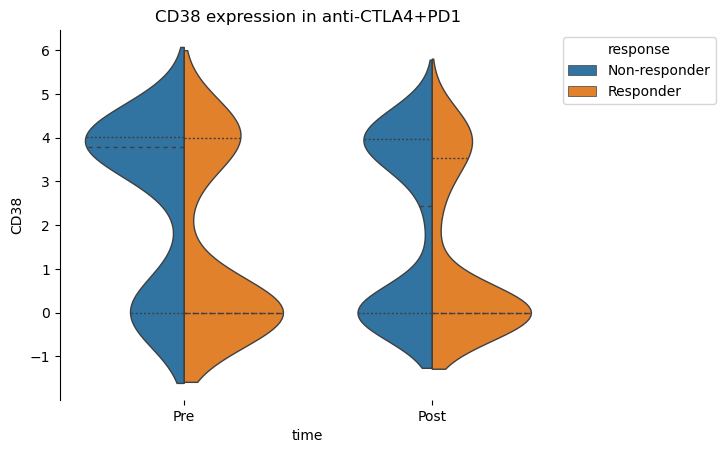

In [16]:
df = sc.get.obs_df(feldman, ["CD38", "time","response","characteristics: therapy"])
ax = sns.violinplot(data=df[df['characteristics: therapy'] == 'anti-CTLA4+PD1'], x='time', y='CD38', hue="response",order=[ "Pre", "Post"],
                    split=True, inner="quart", linewidth=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine(left=False, bottom=True)
ax.set(title='CD38 expression in anti-CTLA4+PD1');

# Figure 2 A-C: Bod et al. 2023

In [2]:
## Import dataset
time = sc.read_h5ad("./timecourse_adata_annotated.h5ad")
## Focus on CD8 T cells
time = time[time.obs['annotation']=="CD8 T cells"]

time.X = None
time.X = time.layers['counts'].copy()
sc.pp.normalize_total(time,target_sum=10000)
time.layers['normcounts'] = time.X.copy()
sc.pp.log1p(time)
time.layers['lognormcounts'] = time.X.copy()


In [3]:
time.obs['group'] = time.obs['tissue'].astype(str) + "_" + time.obs['date'].astype(str)
time.obs['group'] = time.obs['group'].astype("category")

In [4]:
groups=['Tum_d16','Tum_d10','Tum_d7','dLN_d16','dLN_d10','dLN_d7','nLN_d16','nLN_d10','nLN_d7']
time.obs['group_ordered']=pd.Categorical(values=time.obs.group, categories=groups, ordered=True)

In [5]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(1, 1, 1,1), (153/255, 47/255, 152/255,1)]  # White -> Purple
cmap_name = 'cstm_purple'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=500)

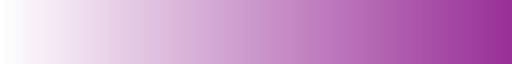

In [6]:
cmap

### Figure 2A

/home/pjoshua/miniconda3/envs/squidpy-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


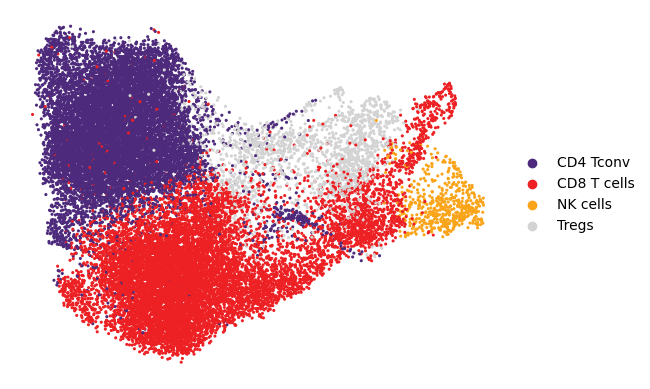

In [49]:
adata.uns['annotation_colors'] = ['#4D2A7C','#ED2024','#FAA41A','#D3D3D3']
fig = sc.pl.umap(adata, color='annotation',frameon=False,return_fig=True,title='',size=20)
plt.savefig('./figures/T_NK_annotated.png', bbox_inches='tight', dpi=550, transparent=True)

/home/pjoshua/miniconda3/envs/squidpy-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


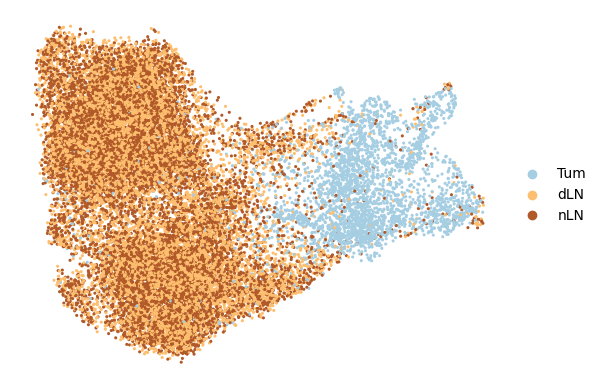

In [48]:
fig = sc.pl.umap(adata, color='tissue',frameon=False,return_fig=True,size=20,title='')
plt.savefig('./figures/T_NK_tissue.png', bbox_inches='tight', dpi=550, transparent=True)

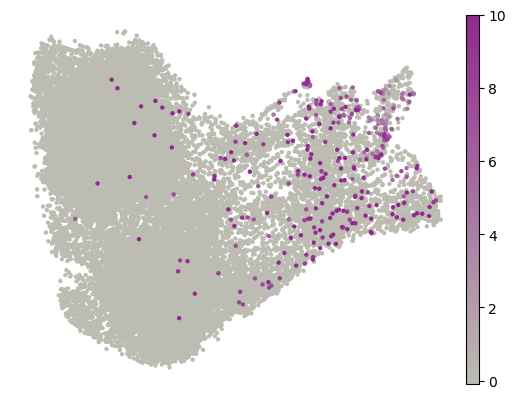

In [11]:
fig = sc.pl.umap(adata,color='Cd38',layer='scaled', return_fig=True, frameon=False,
                 cmap = LinearSegmentedColormap.from_list('PuGr', ['#BCBCB3','#91278F'], N=20000),size=40,title='')
fig.savefig("./figures/T_NK_Cd38_scaled.png", dpi=300,transparent=True)

### Figure 2B

/home/pjoshua/miniconda3/envs/squidpy-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


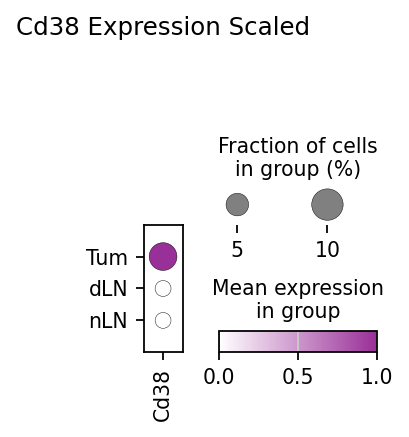

In [11]:
sc.set_figure_params(dpi_save=750, fontsize=11)
sc.pl.dotplot(time, ["Cd38"], groupby='tissue',standard_scale="var", title="Cd38 Expression Scaled", cmap=cmap,
             save="fig1k.png",smallest_dot=50)

### Figure 2C

/home/pjoshua/miniconda3/envs/squidpy-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


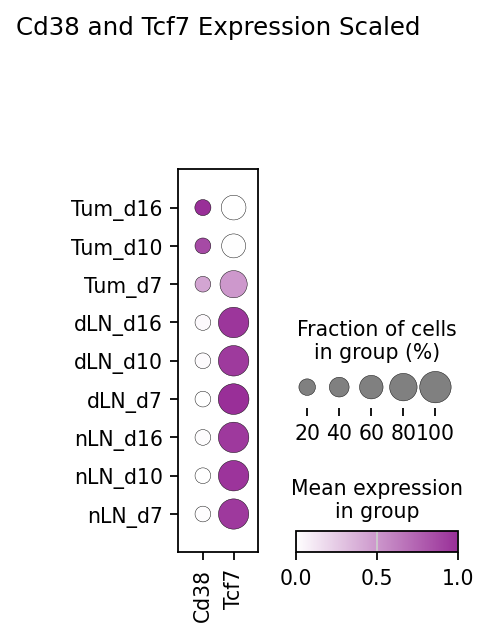

In [8]:
sc.set_figure_params(dpi_save=550, fontsize=11)
sc.pl.dotplot(time, ["Cd38","Tcf7"], groupby='group_ordered',standard_scale="var", title="Cd38 and Tcf7 Expression Scaled", cmap=cmap,
             dot_min=0.1, save="fig1l.pdf",smallest_dot=50)

# Suppl Figure 1: Sade-Feldman et al. 2018

### S1F

In [2]:
feldman = sc.read_h5ad("./adatas/feldman_2018_celltyped.h5ad")
cd8s = {"Exhausted CD8+ T Cells","Exhausted/HS CD8+ T Cells"}
feldman = feldman[feldman.obs.Celltype.isin(cd8s)]

feldman.layers['orig'] = feldman.X.copy()
sc.pp.normalize_total(feldman,target_sum=100000)
feldman.layers['normcounts'] = feldman.X.copy()
sc.pp.log1p(feldman)
feldman.layers['lognormcounts'] = feldman.X.copy()
sc.tl.pca(feldman, svd_solver='arpack')
sc.pp.neighbors(feldman, n_neighbors=5, n_pcs=50)
sc.tl.umap(feldman)
sc.tl.tsne(feldman)

feldman.obs['response'] = feldman.obs['characteristics: response']
feldman.obs['time'] = feldman.obs['characteristics: patient ID (Pre=baseline; Post= on treatment)'].str.split("_").str[0]
feldman

/home/pjoshua/miniconda3/envs/squidpy-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 3878 × 55737
    obs: 'Sample name', 'title', 'source name', 'organism', 'characteristics: patient ID (Pre=baseline; Post= on treatment)', 'characteristics: response', 'characteristics: therapy', 'Cluster number', 'Celltype', 'response', 'time'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'TPM', 'orig', 'normcounts', 'lognormcounts'
    obsp: 'distances', 'connectivities'

In [19]:
sns.set(font_scale=1.5)

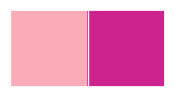

In [13]:
sequential_colors = sns.color_palette("RdPu", 2)
sns.palplot(sequential_colors)

In [20]:
palette = ["#808080", "#992F98"]

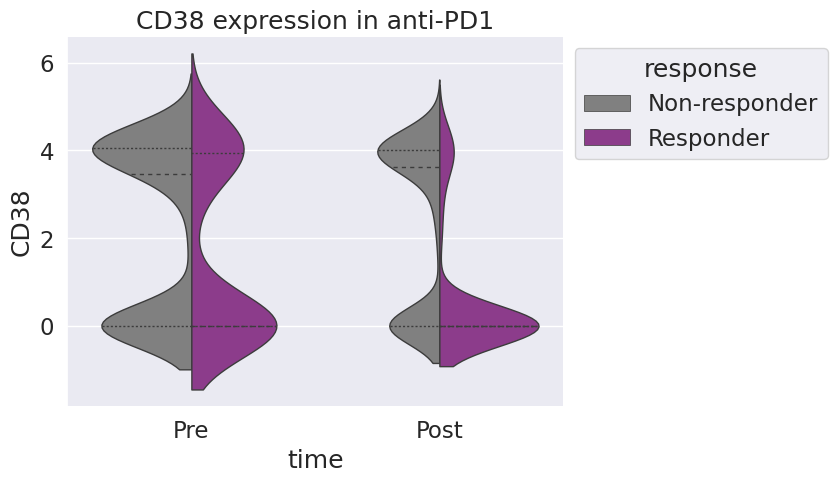

In [24]:
df = sc.get.obs_df(feldman, ["CD38", "time","response","characteristics: therapy"])
ax = sns.violinplot(data=df[df['characteristics: therapy'] == 'anti-PD1'], x='time', y='CD38', hue="response",order=[ "Pre", "Post"],
                    split=True, inner="quart", linewidth=1, legend=False, palette=sns.color_palette(palette, 2))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine(left=False, bottom=True)
ax.set(title='CD38 expression in anti-PD1');
ax.figure.savefig('cd38_expr_in_aPD1.png',dpi=600, bbox_inches='tight')

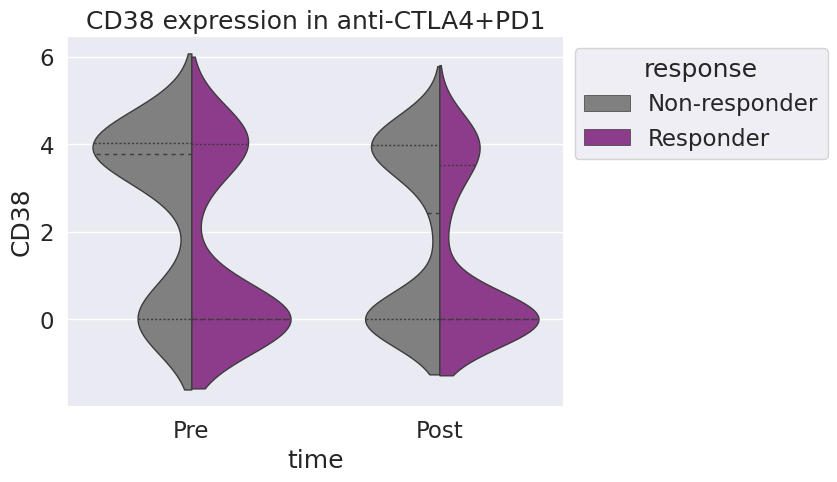

In [25]:
df = sc.get.obs_df(feldman, ["CD38", "time","response","characteristics: therapy"])
ax = sns.violinplot(data=df[df['characteristics: therapy'] == 'anti-CTLA4+PD1'], x='time', y='CD38', hue="response",order=[ "Pre", "Post"],
                    split=True, inner="quart", linewidth=1, palette=sns.color_palette(palette, 2))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine(left=False, bottom=True)
ax.set(title='CD38 expression in anti-CTLA4+PD1');
ax.figure.savefig('cd38_expr_in_CTLA4_aPD1.png',dpi=600, bbox_inches='tight')

# Sup Figure 3A: Bod et al.2023

In [10]:
adata = sc.read_h5ad("timecourse_adata_annotated.h5ad")


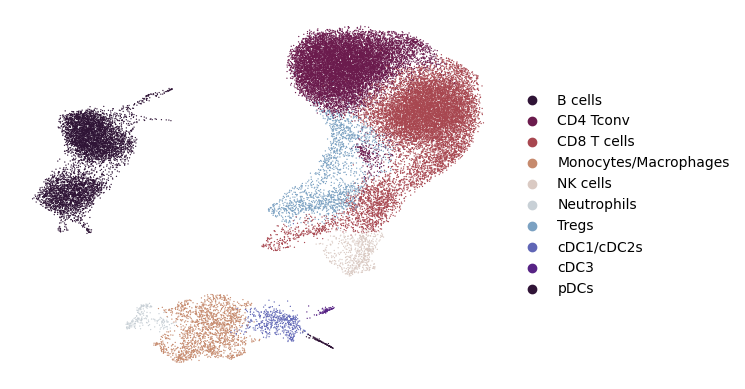

In [14]:
sc.pl.umap(adata, color='annotation', frameon=False, title='', save='_umap_Annotation_timecourse.pdf')

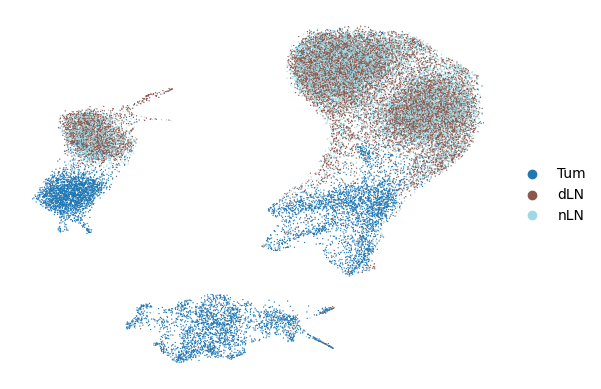

In [15]:
sc.pl.umap(adata, color='tissue', frameon=False, title='', save='_umap_tissue_timecourse.pdf')

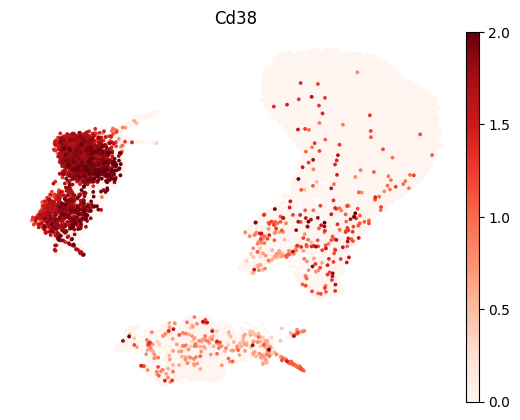

In [28]:
import matplotlib.pyplot as plt

sc.pl.umap(
    adata,
    color='Cd38',
    frameon=False,
    size=30,
    cmap='Reds',
    vmin=0,
    vmax=2,
    show=False,  
    save=None,  
)

cb = plt.gca().collections[-1].colorbar
cb.set_ticks([0, 0.5, 1, 1.5, 2])  

plt.savefig('_umap_cd38_timecourse.pdf', bbox_inches='tight')
plt.show()
